In [1]:
#导入
import pandas as pd
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
from matplotlib import pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#超参数
dimension = 10
dimension_QKV = 10
seq_length = 25
batch_size = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epoch = 10
learning_rate = 0.0005
momentum = 0.05
print("running on ", device)

running on  cpu


D:\Anaconda_\envs\python39\lib\site-packages\torch\cuda\__init__.py:88: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\cuda\CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
#读入数据
raw_data = pd.read_csv('Tetuan City power consumption.csv')
data1 = []
data2 = []
data3 = []
for iter in raw_data.values:
    date = []
    for t in re.split(r'[/: ]', iter[0]):
        try:
            date.append(float(t))
        except ValueError:
            pass
    data1.append(torch.tensor([date[0], date[1], date[3], date[4], iter[1], iter[2], iter[3], iter[4], iter[5], iter[6]]))
    data2.append(torch.tensor([date[0], date[1], date[3], date[4], iter[1], iter[2], iter[3], iter[4], iter[5], iter[7]]))
    data3.append(torch.tensor([date[0], date[1], date[3], date[4], iter[1], iter[2], iter[3], iter[4], iter[5], iter[8]]))
print(len(data1))

52416


In [3]:
#自定义数据集
class ConsumptionDataset(Dataset):
    def __init__(self, data_list):
        self.X = []
        self.y = []
        mask = torch.ones(dimension, seq_length)
        mask[-1][-1] = 0
        for data in data_list:
            start = 0
            end = len(data) - seq_length
            for i in range(start, end):
                input = torch.stack(data[i : i + seq_length], dim=1) * mask
                label = data[i + seq_length - 1][-1]
                self.X.append(input)
                self.y.append(label)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_dataset = ConsumptionDataset([data1, data2])
test_dataset = ConsumptionDataset([data3])
len(train_dataset)

104782

In [4]:
#生成数据加载器
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [5]:
#分数计算及归一层，
class ScaleDotProduct(nn.Module):
    def __init__(self):
        super(ScaleDotProduct, self).__init__()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, q, K, V):
        len = q.size(0)
        q = q.permute(0, 2, 1)
        A = torch.matmul(q, K).squeeze(1)
        A = self.softmax(A)
        output = torch.zeros((len, dimension_QKV)).to(device)
        for i in range(len):
            for j in range(seq_length):
                output[i] += (A[i][j] * V[i, :, j])
        return output

In [6]:
#模型主体
class SelfAttention(nn.Module):
    def __init__(self):
        super(SelfAttention, self).__init__()
        self.W_Q = nn.Linear(10, 10, False)
        self.W_K = nn.Linear(seq_length, seq_length, False)
        self.W_V = nn.Linear(seq_length, seq_length, False)
        self.Scale_Layer = ScaleDotProduct()
        self.fc = nn.Linear(dimension, 1, True)
        
    def forward(self, i):
        q = self.W_Q(i[:, :, -1]).unsqueeze(-1)
        K = self.W_K(i)
        V = self.W_V(i)
        context = self.Scale_Layer(q, K, V)
        consumption = self.fc(context)
        return consumption      

In [13]:
#训练函数
def train(model, epoch, loss_fun, optimizer):
    for i, data in enumerate(train_loader):
        input, output = data
        optimizer.zero_grad()
        input = input.to(device)
        output = output.to(device)
        predict = model(input)
        predict = predict.squeeze(1)
        loss = loss_fun(predict, output)
        loss.backward()
        optimizer.step()
        if(i % 300 == 1):
            print(f'epoch {epoch}, batch {i}, loss {loss}')

#测试模型            
def test(model, loss_fun):
    predicts = None
    with torch.no_grad():
        for data in test_loader:
            input, output = data
            input = input.to(device)
            output = output.to(device)
            predict = model(input)
            if predicts == None:
                predicts = predict
                outputs = output
            else:
                predicts = torch.cat([predicts, predict], 0)
                outputs = torch.cat([outputs, output], 0)
        print(len(predicts))
        print(len(outputs))
        loss = loss_fun(predicts, output)
        print(f'MSELoss on test set : {loss}')
        return loss   

In [ ]:
#训练模型
net = SelfAttention().to(device)
loss_fun = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), learning_rate)
MSELoss_list = []
min = None
for i in range(epoch):
    train(net, i, loss_fun, optimizer)
    loss = test(net, loss_fun=loss_fun)
    MSELoss_list.append(loss)
    if min == None or loss < min:
        min = loss
        torch.save(net.state_dict(), "best_model.pt")
plt.plot(MSELoss_list)
plt.xlabel('Epoch')
plt.ylabel('MSELoss On TestSet')
plt.show()

torch.Size([64])
torch.Size([64])


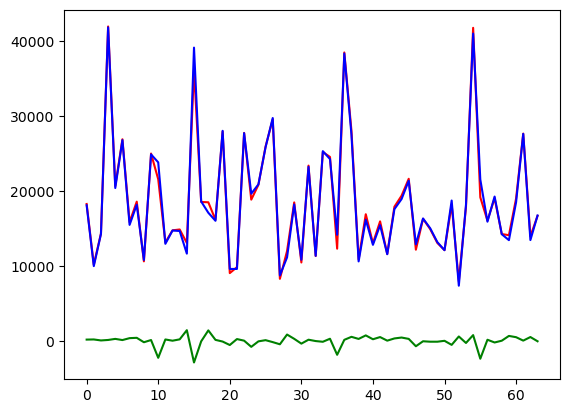

In [42]:
#康康训练好的模型
net = torch.load("best_model.pt", map_location=torch.device('cpu'))
with torch.no_grad():
    for data in test_loader:
        input, ans = data
        predict = net(input).squeeze(1)
        print(predict.shape)
        print(ans.shape)
        plt.plot(np.array(predict.numpy()), 'r')
        plt.plot(np.array(ans.numpy()), 'b')
        plt.plot(np.array((predict - ans).numpy()), 'g')
        break
